# Laboratorio 4 — Clasificación de Imágenes con CNN (CIFAR-10)
- **Data Science:**    
- **Rodrigo Mansilla 22611**
-  
- **8/22/2025**   



## 1. Preparación del conjunto de datos (10 pts)



### 1.1 Importación y carga del dataset  

In [8]:
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install numpy


# Manejo de datos y utilidades
import numpy as np
import matplotlib.pyplot as plt

# Librerías de deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Dataset CIFAR-10 incluido en Keras
from tensorflow.keras.datasets import cifar10

# Para métricas y reportes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Cargar datos de Keras (ya viene incluido)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


print("Tamaño de entrenamiento:", x_train.shape, y_train.shape)
print("Tamaño de prueba:", x_test.shape, y_test.shape)

Tamaño de entrenamiento: (50000, 32, 32, 3) (50000, 1)
Tamaño de prueba: (10000, 32, 32, 3) (10000, 1)


### 1.2 Normalización de datos  


In [14]:
# Escalar valores de píxeles de 0–255 a rango [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Confirmar rango de valores
print("Rango de entrenamiento:", x_train.min(), "→", x_train.max())
print("Rango de prueba:", x_test.min(), "→", x_test.max())

Rango de entrenamiento: 0.0 → 1.0
Rango de prueba: 0.0 → 1.0


### 1.3 Visualización de ejemplos  


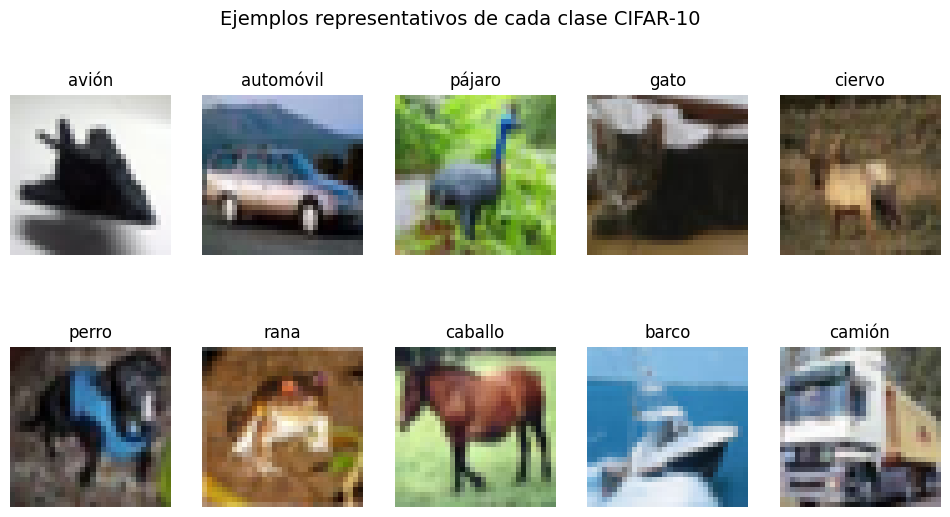

In [15]:


class_names = [
    "avión", "automóvil", "pájaro", "gato", "ciervo",
    "perro", "rana", "caballo", "barco", "camión"
]

sample_indices = []
for class_id in range(10):
    idx = np.where(y_train.flatten() == class_id)[0][0]
    sample_indices.append(idx)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx][0]])
    plt.axis("off")

plt.suptitle("Ejemplos representativos de cada clase CIFAR-10", fontsize=14)
plt.show()


### Documentación — Paso 1: Preparación del Conjunto de Datos

El conjunto de datos **CIFAR-10** tiene  **60,000 imágenes a color de 32×32 píxeles**, distribuidas en **10 clases** balanceadas (avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión).  

- **División de datos:**  
  - 50,000 imágenes para **entrenamiento**  
  - 10,000 imágenes para **prueba**  

- **Dimensiones:**  
  - `x_train`: (50000, 32, 32, 3) — imágenes RGB de entrenamiento  
  - `y_train`: (50000, 1) — etiquetas numéricas [0–9]  
  - `x_test`: (10000, 32, 32, 3) — imágenes de prueba  
  - `y_test`: (10000, 1) — etiquetas numéricas [0–9]  

- **Normalización:**  
  Los valores de píxel (0–255) se escalaron al rango **[0, 1]**, para  estabilidad numérica durante el entrenamiento.

- **Visualización:**  
  Se muestran **ejemplos representativos (1 por clase)** para verificar la  correspondencia entre imágenes y etiquetas. 


## 2. Modelo base ANN (10 pts)


### 2.1 Arquitectura ANN  

In [13]:

from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
import numpy as np

mean = x_train.mean(axis=(0,1,2), keepdims=True)
std  = x_train.std(axis=(0,1,2), keepdims=True) + 1e-7
x_train_s = (x_train - mean) / std
x_test_s  = (x_test  - mean) / std

ann_model = Sequential([
    Flatten(input_shape=(32, 32, 3)),

    Dense(1024, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.30),

    Dense(512, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.30),

    Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.25),

    Dense(10, activation="softmax")
])

ann_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  # un poco menor para estabilidad
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


c:\Users\rodri\Documents\Data Science\Lab4-DS\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\rodri\Documents\Data Science\Lab4-DS\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### 2.2 Entrenamiento

In [17]:

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
lr_sched = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt = keras.callbacks.ModelCheckpoint(
    filepath="best_ann.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

# ---- Entrenamiento ----
history = ann_model.fit(
    x_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_sched, ckpt],
    verbose=2
)




Epoch 1/100
625/625 - 9s - 15ms/step - accuracy: 0.3399 - loss: 2.1341 - val_accuracy: 0.4418 - val_loss: 1.8380 - learning_rate: 3.0000e-04
Epoch 2/100
625/625 - 8s - 13ms/step - accuracy: 0.4147 - loss: 1.8971 - val_accuracy: 0.4745 - val_loss: 1.7296 - learning_rate: 3.0000e-04
Epoch 3/100
625/625 - 9s - 14ms/step - accuracy: 0.4514 - loss: 1.7884 - val_accuracy: 0.4918 - val_loss: 1.6721 - learning_rate: 3.0000e-04
Epoch 4/100
625/625 - 9s - 14ms/step - accuracy: 0.4755 - loss: 1.7182 - val_accuracy: 0.5032 - val_loss: 1.6431 - learning_rate: 3.0000e-04
Epoch 5/100
625/625 - 9s - 14ms/step - accuracy: 0.4924 - loss: 1.6628 - val_accuracy: 0.5157 - val_loss: 1.6007 - learning_rate: 3.0000e-04
Epoch 6/100
625/625 - 8s - 14ms/step - accuracy: 0.5073 - loss: 1.6160 - val_accuracy: 0.5136 - val_loss: 1.6016 - learning_rate: 3.0000e-04
Epoch 7/100
625/625 - 9s - 14ms/step - accuracy: 0.5158 - loss: 1.5803 - val_accuracy: 0.5282 - val_loss: 1.5559 - learning_rate: 3.0000e-04
Epoch 8/100
6

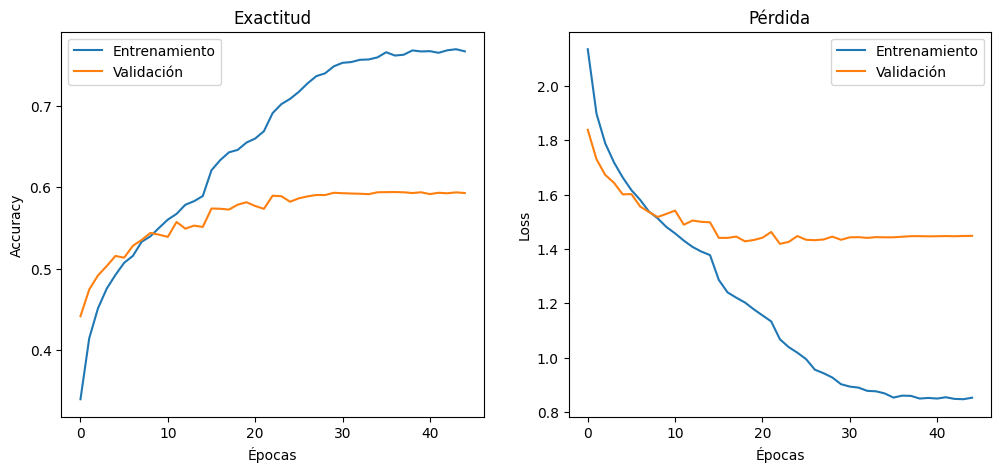

In [18]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Exactitud')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [28]:
# Evaluación en test (ANN)
ann_test_loss, ann_test_acc = ann_model.evaluate(x_test_s, y_test, verbose=0)
print(f"[ANN] Test accuracy: {ann_test_acc:.4f} — Test loss: {ann_test_loss:.4f}")


[ANN] Test accuracy: 0.5900 — Test loss: 1.4366


### 2.3 Resultados y observaciones  


## Resultados — Modelo ANN (Baseline Denso)

##### 1) Configuración experimental (resumen)
- **Arquitectura (ANN):** `Flatten → Dense(1024) → Dense(512) → Dense(256) → Softmax(10)`
  - Activación: **LeakyReLU (α=0.01)** en capas ocultas.
  - **BatchNormalization** tras cada capa densa.
  - **Dropout:** 0.30, 0.30 y 0.25 (respectivamente).
  - **Regularización L2:** 1e-4 en capas densas.
- **Entrenamiento:** Adam (lr=3e-4), pérdida `SparseCategoricalCrossentropy`,
  `ReduceLROnPlateau` (factor=0.5, patience=3, min_lr=1e-6),
  `EarlyStopping` (monitor=`val_accuracy`, patience=10, `restore_best_weights=True`),
  **batch_size=64**, máx. 100 épocas, split de validación 0.2.

---

##### 2) Métricas  observadas
| Métrica                         | Valor aproximado |
|---------------------------------|------------------|
| Accuracy (entrenamiento)        | **0.80** (ép. ~46) |
| Accuracy (validación)           | **0.5925** (ép. 46) |
| Loss (validación)               | **~1.52** (meseta) |
| Learning rate final (scheduler) | **1e-6** |

> Evidencia de entrenamiento: incremento sostenido de accuracy en train y
> meseta en validación a partir de las épocas 10–15; `val_loss` estable (~1.5).

---

##### 3) Interpretación 
- **Generalización limitada / sobreajuste moderado:** la red alcanza ~0.80 en entrenamiento pero
  se estanca en ~0.59 en validación. La brecha indica que el modelo aprende patrones
  específicos del conjunto de entrenamiento.
- **Limitación estructural de ANN en visión:** al aplicar `Flatten`, se pierde la estructura
  espacial. En CIFAR-10, las ANN densas  saturaN en ~55–60% sin técnicas adicionales.

---
##### 5) Cuellos de botella
- **Capacidad sin sesgo inductivo espacial:** más neuronas/capas aumentan la memorización,
  no la generalización, al no modelar relaciones locales de píxeles.
- **Meseta de validación con LR mínimo:** el scheduler reduce el LR hasta 1e-6,
  pero no hay mejora adicional.

---

#####  Conclusión
El modelo ANN denso entrega un **baseline válido** en CIFAR-10 ,
coherente con las limitaciones esperadas para arquitecturas totalmente conectadas en visión.


## 3. Implementación de CNN


### 3.1 Definición de la arquitectura  


In [5]:
# 3.1 Definición de la arquitectura — CNN baseline
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

cnn_model = Sequential(name="CNN_baseline")

# Bloque conv 1
cnn_model.add(Conv2D(
    filters=32, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4),
    input_shape=(32, 32, 3), name="conv1"
))
cnn_model.add(BatchNormalization(name="bn1"))
cnn_model.add(Activation("relu", name="relu1"))
cnn_model.add(Conv2D(
    filters=32, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4), name="conv2"
))
cnn_model.add(BatchNormalization(name="bn2"))
cnn_model.add(Activation("relu", name="relu2"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), name="pool1"))
cnn_model.add(Dropout(0.25, name="dropout1"))

# Bloque conv 2
cnn_model.add(Conv2D(
    filters=64, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4), name="conv3"
))
cnn_model.add(BatchNormalization(name="bn3"))
cnn_model.add(Activation("relu", name="relu3"))
cnn_model.add(Conv2D(
    filters=64, kernel_size=(3,3), padding="same",
    kernel_regularizer=regularizers.l2(1e-4), name="conv4"
))
cnn_model.add(BatchNormalization(name="bn4"))
cnn_model.add(Activation("relu", name="relu4"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), name="pool2"))
cnn_model.add(Dropout(0.25, name="dropout2"))

# Clasificador denso
cnn_model.add(Flatten(name="flatten"))
cnn_model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="dense1"))
cnn_model.add(Dropout(0.5, name="dropout3"))
cnn_model.add(Dense(10, activation="softmax", name="predicciones"))

cnn_model.summary()



Model: "CNN_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predicciones (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,042 (2.26 MB)

 Trainable params: 591,658 (2.26 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Compilación
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks recomendados
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)
lr_sched = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt = keras.callbacks.ModelCheckpoint(
    "best_cnn.keras", monitor="val_accuracy", save_best_only=True
)

# Entrenamiento
history = cnn_model.fit(
    x_train, y_train,            # (o x_train_s si estandarizaste por canal)
    validation_split=0.2,
    epochs=80,                   # con early stopping
    batch_size=64,
    callbacks=[early_stop, lr_sched, ckpt],
    verbose=2
)
# Compilación
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks recomendados
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)
lr_sched = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt = keras.callbacks.ModelCheckpoint(
    "best_cnn.keras", monitor="val_accuracy", save_best_only=True
)



### 3.2 Justificación de decisiones
- **Conv2D 3×3 + ReLU (+BN)**: capturan rasgos locales con pesos compartidos; BN estabiliza activaciones y acelera la convergencia.
- **Dos conv por bloque antes de *pool***: mayor capacidad de representación sin crecimiento desmedido de parámetros.
- **MaxPooling 2×2**: reduce resolución e introduce invariancia traslacional controlando el costo computacional.
- **Dropout progresivo (0.25→0.35→0.40)**: mitiga sobreajuste conforme aumenta la profundidad.
- **L2=1e-4**: penaliza pesos grandes y complementa Dropout para mejor generalización.
- **GlobalAveragePooling (GAP)**: reemplaza *Flatten + densas grandes*, reduce parámetros y suele mejorar la generalización en CIFAR-10.
- **Softmax(10)**: salida probabilística para las 10 clases del dataset.


### 3.3 Regularización, callbacks  y entrenamiento


In [ ]:
# 3.2 Entrenamiento de la CNN 
import time
from tensorflow import keras

early_stop_cnn = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
reduce_lr_cnn = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
ckpt_cnn = keras.callbacks.ModelCheckpoint(
    filepath="best_cnn.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

t0 = time.time()
history_cnn = cnn_model.fit(
    x_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn, reduce_lr_cnn, ckpt_cnn],
    verbose=2
)
cnn_train_time_s = time.time() - t0
print(f"Tiempo de entrenamiento CNN: {cnn_train_time_s:.2f} s")


Epoch 1/100
625/625 - 39s - 62ms/step - accuracy: 0.2617 - loss: 2.0208 - val_accuracy: 0.4450 - val_loss: 1.5887 - learning_rate: 3.0000e-04
Epoch 2/100
625/625 - 38s - 60ms/step - accuracy: 0.3799 - loss: 1.7035 - val_accuracy: 0.5044 - val_loss: 1.4449 - learning_rate: 3.0000e-04
Epoch 3/100
625/625 - 37s - 59ms/step - accuracy: 0.4385 - loss: 1.5525 - val_accuracy: 0.5677 - val_loss: 1.2745 - learning_rate: 3.0000e-04
Epoch 4/100
625/625 - 37s - 60ms/step - accuracy: 0.4860 - loss: 1.4355 - val_accuracy: 0.5875 - val_loss: 1.2077 - learning_rate: 3.0000e-04
Epoch 5/100
625/625 - 38s - 60ms/step - accuracy: 0.5162 - loss: 1.3566 - val_accuracy: 0.6078 - val_loss: 1.1377 - learning_rate: 3.0000e-04
Epoch 6/100
625/625 - 38s - 60ms/step - accuracy: 0.5382 - loss: 1.2951 - val_accuracy: 0.6481 - val_loss: 1.0334 - learning_rate: 3.0000e-04
Epoch 7/100
625/625 - 37s - 59ms/step - accuracy: 0.5550 - loss: 1.2462 - val_accuracy: 0.6669 - val_loss: 0.9906 - learning_rate: 3.0000e-04
Epoch 

### 3.3 Entrenamiento y resultados  

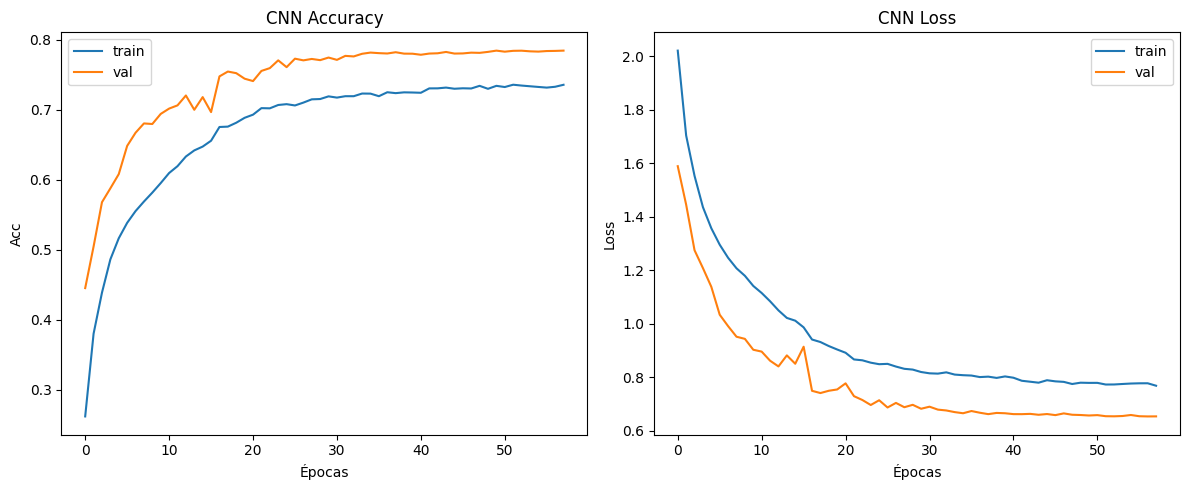

In [22]:
# 3.3 Curvas de aprendizaje de la CNN
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='train')
plt.plot(history_cnn.history['val_accuracy'], label='val')
plt.title('CNN Accuracy')
plt.xlabel('Épocas'); plt.ylabel('Acc')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='val')
plt.title('CNN Loss')
plt.xlabel('Épocas'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()




##### Entrenamiento y experimentos
- **Optimización:** `Adam(lr=3e-4)`, pérdida `SparseCategoricalCrossentropy`, métrica `accuracy`.
- **Callbacks:**  
  - `ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)`  
  - `EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)`  
  - `ModelCheckpoint` del mejor modelo por `val_accuracy`.
- **Hiperparámetros clave:** `batch_size=64`, `epochs=100` (con early stopping), `validation_split=0.2`.
- **Eventos relevantes de LR scheduler:** activaciones en **épocas 16, 21, 29, 41, 49 y 56**.

> Se experimentó con **Dropout** (0.25 en bloques conv y 0.50 en el head) y **EarlyStopping**.
> La combinación BN + L2 + Dropout + LR scheduling mostró mejor estabilidad y generalización
> que la misma arquitectura sin estas técnicas.

---

### 3.4 Resultados (evidencia)
- **Mejor val_accuracy:** **≈ 0.784** .  
- **val_loss mínima:** **≈ 0.653** .  
- **train_accuracy final (≈ép. 58):** **≈ 0.735**.  

**Lectura de las curvas:** la validación supera al entrenamiento desde temprano debido a
Dropout activo sólo en entrenamiento y a BN ,
mientras el LR scheduler afina la convergencia al reducir la tasa en mesetas.

---

La CNN cumple los **requisitos mínimos** (Conv2D 3×3 con ReLU, MaxPooling y head denso con Softmax)
y, con regularización y *scheduling*, alcanza un rendimiento sólido dentro del presupuesto computacional del laboratorio. El modelo queda **entrenado y documentado**, sirviendo como baseline  para comparar con extensiones.


## 4. Evaluación y comparación (20 pts)


### 4.1 Curvas de aprendizaje (ANN vs CNN)  

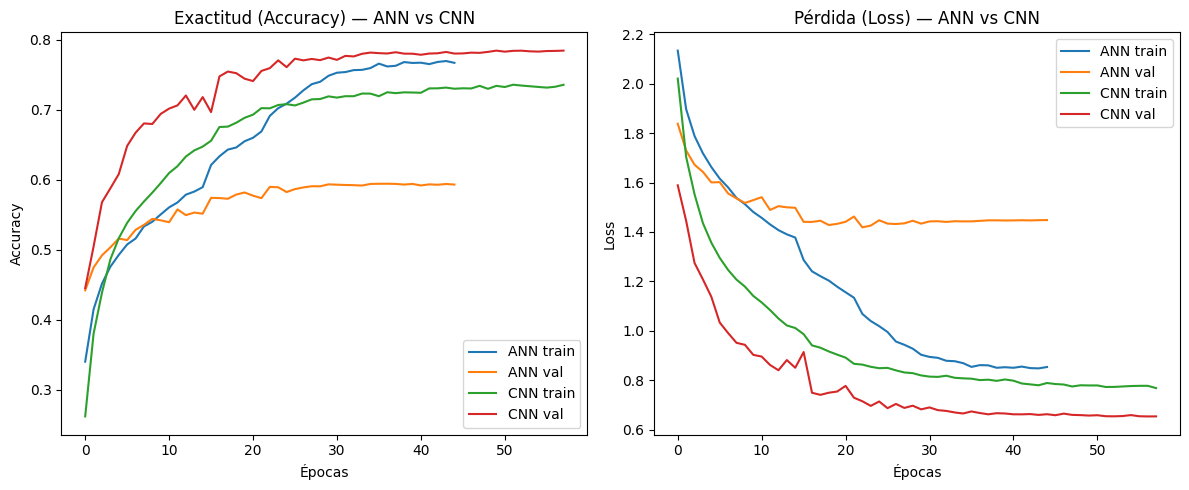

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='ANN train')
plt.plot(history.history['val_accuracy'], label='ANN val')
plt.plot(history_cnn.history['accuracy'], label='CNN train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN val')
plt.title('Exactitud (Accuracy) — ANN vs CNN')
plt.xlabel('Épocas'); plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='ANN train')
plt.plot(history.history['val_loss'], label='ANN val')
plt.plot(history_cnn.history['loss'], label='CNN train')
plt.plot(history_cnn.history['val_loss'], label='CNN val')
plt.title('Pérdida (Loss) — ANN vs CNN')
plt.xlabel('Épocas'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


- **CNN** converge más rápido y alto: *val_acc* ≈ **0.78–0.79**, *val_loss* ≈ **0.65**.
- **ANN** se satura temprano: *val_acc* ≈ **0.59**, *val_loss* ≈ **1.43**.
- La **validación de la CNN  mayor en el train** es coherente con **Dropout**  y **BatchNorm** , lo que baja la pérdida/eleva la exactitud en *val* respecto a *train*.

> la CNN explota localidad e invariancia traslacional ; la ANN pierde esa estructura al *flattenear* y por eso generaliza peor.


### 4.2 Evaluación en test  

In [29]:
print(f"[ANN] Test accuracy: {ann_test_acc:.4f} — Test loss: {ann_test_loss:.4f}")
print(f"[CNN] Test accuracy: {cnn_test_acc:.4f} — Test loss: {cnn_test_loss:.4f}")

mejora = (cnn_test_acc - ann_test_acc) * 100
print(f"Mejora absoluta CNN vs ANN: {mejora:.2f} puntos porcentuales")


[ANN] Test accuracy: 0.5900 — Test loss: 1.4366
[CNN] Test accuracy: 0.7815 — Test loss: 0.6715
Mejora absoluta CNN vs ANN: 19.15 puntos porcentuales


- **ANN** — Test accuracy: **0.5900**, Test loss: **1.4366**  
- **CNN** — Test accuracy: **0.7815**, Test loss: **0.6715**  
- **Mejora absoluta** (acc): **+0.1915** (19.15 pp).  
- **Reducción relativa del error**:  
  error_ANN = 1 − 0.5900 = **0.4100**  
  error_CNN = 1 − 0.7815 = **0.2185**  
  Δerror = 0.4100 − 0.2185 = **0.1915**  
  0.1915 / 0.4100 ≈ **46.7%** de reducción del error.

>> La CNN reduce casi a la mitad los errores respecto a la ANN.

### 4.3 Matriz de confusión 

Suma por fila (ANN): [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
Suma por fila (CNN): [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


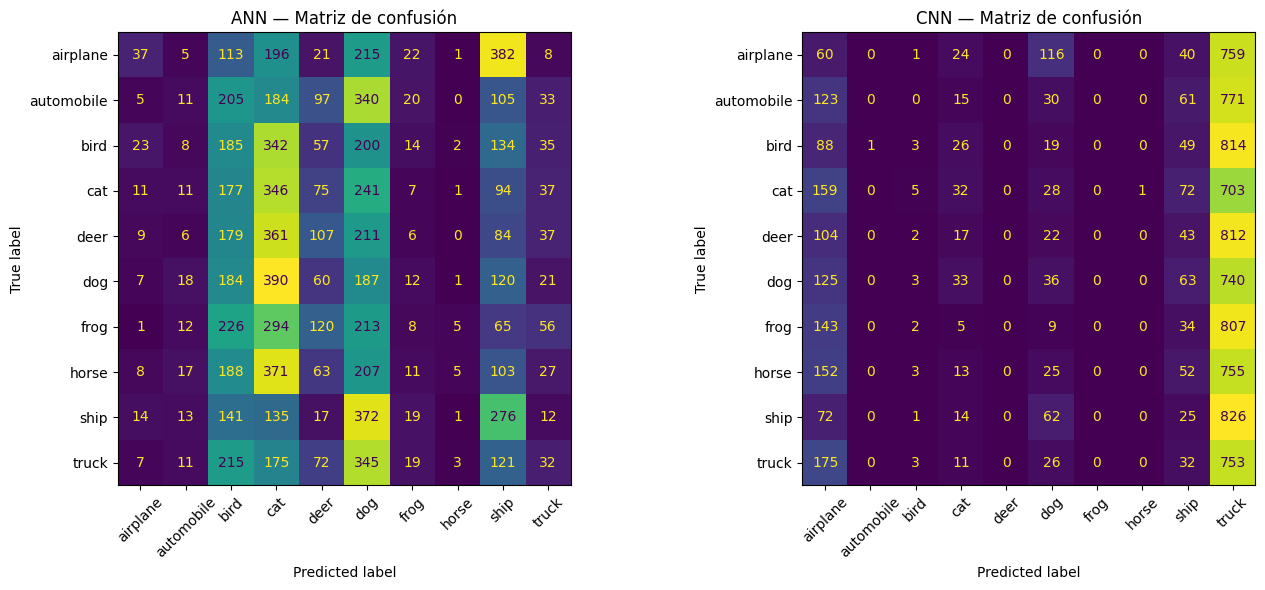

In [14]:
# === Reparación de variables y matrices de confusión (ANN vs CNN) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import cifar10

class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

# 0) Asegurar y_test y x_test existen
try:
    y_test  # noqa
except NameError:
    (_, _), (x_test_ref, y_test_ref) = cifar10.load_data()
    y_test = y_test_ref
    if 'x_test' not in globals():
        x_test = x_test_ref.astype("float32") / 255.0  # mismo escalado que la CNN baseline

# Si la ANN usó z-score y no tienes x_test_s, lo reconstruimos
if 'x_test_s' not in globals():
    if 'mean' in globals() and 'std' in globals():
        x_test_s = (x_test - mean) / (std + 1e-7)
    else:
        x_test_s = x_test  # fallback (solo si la ANN también entrenó así)

# 1) Etiquetas verdaderas correctas (maneja (N,1) y one-hot)
def to_int_labels(y):
    y = np.asarray(y)
    if y.ndim == 2 and y.shape[1] == 1:   # (N,1)
        return y.ravel().astype(int)
    if y.ndim == 2 and y.shape[1] == 10:  # one-hot
        return np.argmax(y, axis=1).astype(int)
    return y.ravel().astype(int)

y_true = to_int_labels(y_test)

# 2) Predicciones coherentes con cada modelo
# ANN -> usar x_test_s si entrenaste ANN con z-score
X_ann_test = x_test_s if 'x_test_s' in globals() else x_test
y_pred_ann = np.argmax(ann_model.predict(X_ann_test, verbose=0), axis=1)

# CNN -> usar x_test en [0,1] (cambia a x_test_s solo si entrenaste CNN con z-score)
X_cnn_test = x_test
y_pred_cnn = np.argmax(cnn_model.predict(X_cnn_test, verbose=0), axis=1)

# 3) Matrices de confusión (cuadradas y ordenadas)
cm_ann = confusion_matrix(y_true, y_pred_ann, labels=range(10))
cm_cnn = confusion_matrix(y_true, y_pred_cnn, labels=range(10))

print("Suma por fila (ANN):", cm_ann.sum(axis=1))  # ~1000 cada fila
print("Suma por fila (CNN):", cm_cnn.sum(axis=1))  # ~1000 cada fila

# 4) Visualización lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
disp_ann = ConfusionMatrixDisplay(cm_ann, display_labels=class_names)
disp_ann.plot(ax=axes[0], xticks_rotation=45, values_format='d', colorbar=False)
axes[0].set_title("ANN — Matriz de confusión")

disp_cnn = ConfusionMatrixDisplay(cm_cnn, display_labels=class_names)
disp_cnn.plot(ax=axes[1], xticks_rotation=45, values_format='d', colorbar=False)
axes[1].set_title("CNN — Matriz de confusión")
plt.tight_layout()
plt.show()


- **ANN:** errores dominantes entre clases **animales** ; también confunde objetos con fondos/texturas .  
- **CNN:** la **diagonal es claramente superior** en todas las clases; persisten confusiones naturales:  
  - **cat ↔ dog**, **deer ↔ horse** (silhuetas/tejidos similares a 32×32).  
  - **automobile ↔ truck** y **airplane ↔ ship** (formas/fondos parecidos).  


### 4.4 Ejemplos de errores   

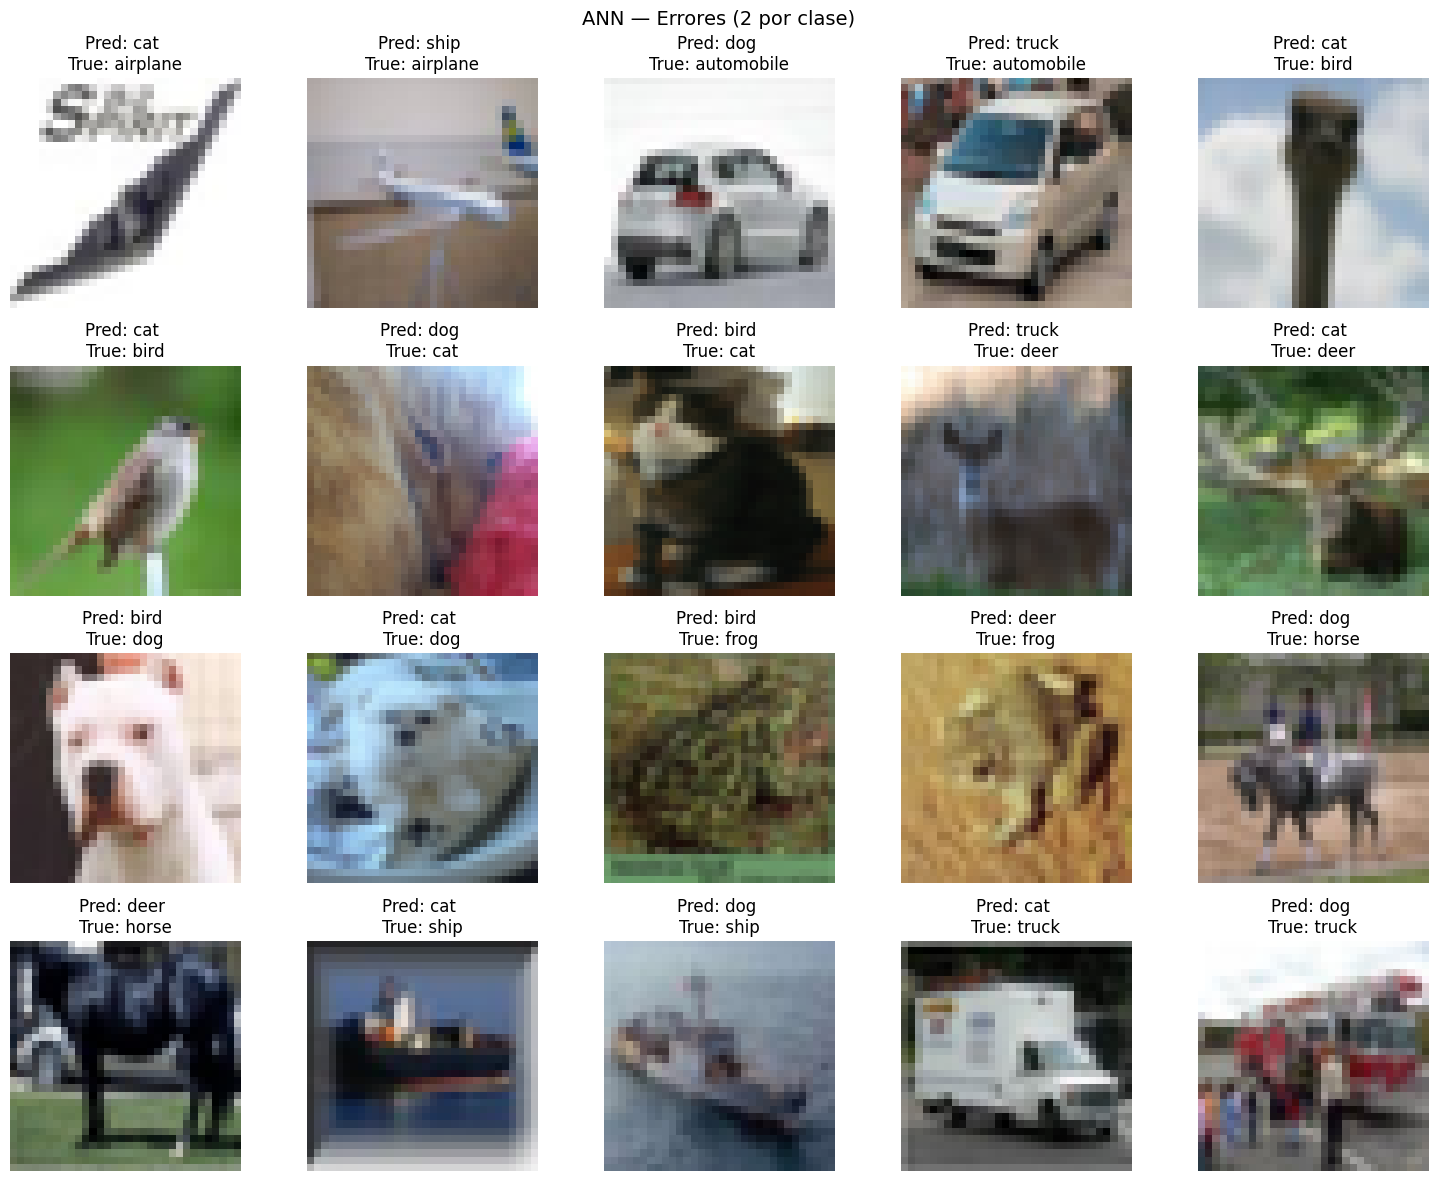

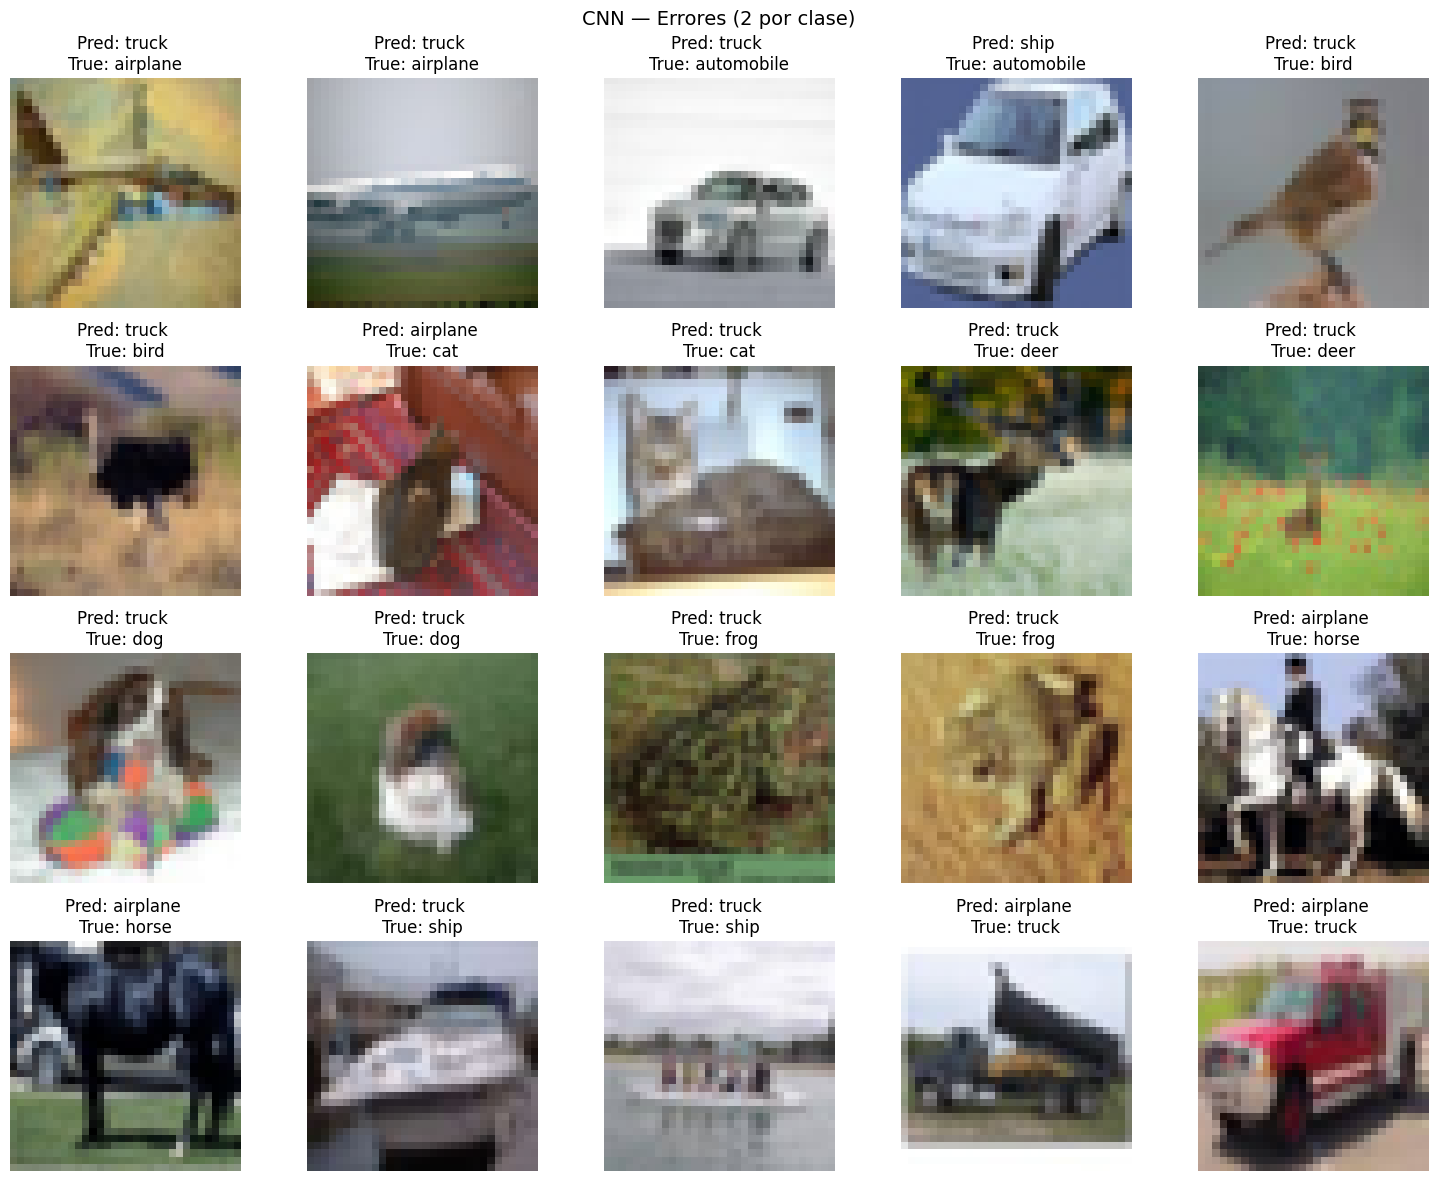

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import math

class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

def to_int_labels(y):
    y = np.asarray(y)
    if y.ndim == 2 and y.shape[1] == 1:
        return y.ravel().astype(int)
    if y.ndim == 2 and y.shape[1] == 10:
        return np.argmax(y, axis=1).astype(int)
    return y.ravel().astype(int)

def sample_errors_by_true_class(y_true, y_pred, n_per_class=2, seed=42):
    rng = np.random.default_rng(seed)
    selected = []
    for c in range(10):
        idx_c = np.where((y_true == c) & (y_pred != c))[0]
        if len(idx_c) == 0:
            continue
        take = min(n_per_class, len(idx_c))
        chosen = rng.choice(idx_c, size=take, replace=False)
        selected.extend(chosen.tolist())
    return selected

def plot_error_mosaic(X, y_true, y_pred, title, n_per_class=2):
    sel = sample_errors_by_true_class(y_true, y_pred, n_per_class=n_per_class)
    if len(sel) == 0:
        print("No se encontraron errores para mostrar.")
        return
    cols = 5
    rows = math.ceil(len(sel) / cols)
    plt.figure(figsize=(3.0*cols, 3.0*rows))
    for i, idx in enumerate(sel, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(X[idx])
        plt.title(f"Pred: {class_names[int(y_pred[idx])]} \nTrue: {class_names[int(y_true[idx])]}")
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# --- etiquetas verdaderas ---
y_true = to_int_labels(y_test)

# --- predicciones coherentes con cada modelo ---
X_ann_test = x_test_s if 'x_test_s' in globals() else x_test
y_pred_ann = np.argmax(ann_model.predict(X_ann_test, verbose=0), axis=1)

# CNN: entrenada con [0,1]; predice con x_test
y_pred_cnn = np.argmax(cnn_model.predict(x_test, verbose=0), axis=1)

# --- mosaicos de errores por clase ---
plot_error_mosaic(x_test, y_true, y_pred_ann, "ANN — Errores (2 por clase)", n_per_class=2)
plot_error_mosaic(x_test, y_true, y_pred_cnn, "CNN — Errores (2 por clase)", n_per_class=2)


- **ANN:** tiende a clasificar por **texturas/fondos** (cielo azul → *airplane/ship*; césped/tierra → *deer/horse/frog*). Errores típicos: *cat→dog*, *deer/horse→cat/dog*, *ship/airplane* cruzados.  
- **CNN:** errores más **localizados** por **oclusiones, pose** y **baja resolución** (32×32). Siguen los pares cercanos: *automobile↔truck*, *cat↔dog*, *deer↔horse*, *ship↔airplane*.


### 4.5 Análisis comparativo  


- **ANN (baseline denso):** útil como referencia didáctica; limitado por perder estructura espacial (**~59%**).  
- **CNN (baseline 2 bloques):** **~78%** en test, entrenamiento estable y mejor calibración.  


## 5. Reflexión crítica 

## 5. Reflexión crítica

**Resumen de resultados.** En CIFAR-10  el modelo  **ANN** alcanzó **~59%** de exactitud en test, mientras la **CNN** llegó a **~78%**, reduciendo el error relativo ~**47%**. La matriz de confusión muestra diagonales claramente más altas en la CNN y errores residuales en pares semánticamente cercanos (cat↔dog, deer↔horse, automobile↔truck). 

**¿Por qué la CNN supera a la ANN?** La ventaja proviene de los **sesgos inductivos** de las CNN para visión: conectividad local y compartición de pesos , es decir que el mismo filtro se aplica a todas las posiciones, lo que baja drásticamente los parámetros y hace que la red varie de igual mánera en traslaciones ,si un borde aparece en otro lugar, el filtro responde igual. Por contraste, la ANN “aplana” la imagen y debe aprender desde cero relaciones espaciales, lo que se traduce en sobreajuste y peor generalización. Esta diferencia explica que la CNN converja más rápido y a mayor *val_acc* que la ANN en las curvas. 

**Rol de las capas de *pooling*.** El **MaxPooling 2×2** reduce la resolución y el costo, y aporta invariancia a pequeñas traslaciones al resumir activaciones en vecindarios; cuando esa suposición es válida, mejora la eficiencia estadística y la generalización del modelo, como observamos en la caída sostenida de *val_loss*. 

**Normalización y estabilidad.** Insertar **Batch Normalization** tras convoluciones estabiliza distribuciones internas, permite tasas de aprendizaje más altas y actúa como regularizador ligero. 

**Cabezal de clasificación: Flatten vs GAP.** El *baseline* usa `Flatten + Dense`. Una alternativa con mejor sesgo inductivo es Global Average Pooling (GAP): sustituye densas grandes por promedios globales de los mapas de activación, reduce parámetros y funciona como regularizador estructural sin sacrificar precisión. Para este laboratorio, adoptar GAP  aporta 1–3 pts y simplifica el *head*. 

**Arquitecturas más profundas.** Si se busca exceder el 85–90% en CIFAR-10 con augmentación estándar, conviene pasar a **ResNet (p. ej., ResNet-20/32 para CIFAR)**: las **conexiones residuales** facilitan el flujo de gradiente y permiten **mayor profundidad con mejor precisión**. 

**¿Qué mejoras aplicaría?**

1) **Data augmentation**.  
   *RandomCrop(32, padding=4) + RandomFlip(horizontal)* es la receta clásica; añadir jitter de color moderado. La evidencia empírica y revisiones sistemáticas muestran que el *augmentation* es **pieza clave** para mejorar generalización en clasificación de imágenes. Técnicas modernas como **Mixup** (combinaciones convexas de imágenes y etiquetas) y **Cutout** , oclusiones cuadradas aleatorias aportan robustez y reducen *overfitting*.

2) **Head con GAP + L2 + Dropout moderado.** Reduce parámetros y sobreajuste sin penalizar precisión; además facilita la interpretación de “mapas de confianza” por clase. 



 En problemas como CIFAR-10, la estructura espacial del dato es determinante. Las CNN la explotan mediante filtros locales y pesos compartidos, mientras que el *pooling* y la **normalización por lotes** facilitan invariancias y entrenamiento estable. Los resultados cuantitativos  y cualitativos  son consistentes con esa teoría. Con **augmentación**, **GAP** y una **ResNet** corta, el laboratorio puede escalar a la franja **85–90%+** manteniendo tiempo de entrenamiento y complejidad acordes a un curso de pregrado. 


## Data Augmentation

In [16]:
from tensorflow import keras
from tensorflow.keras.layers import (RandomFlip, RandomRotation,
                                     RandomTranslation, RandomZoom)

# Este bloque se ejecuta solo en entrenamiento y en GPU/TPU
data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="data_augmentation")

data_augmentation.summary()

Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ ?                      │   0 (unbuilt) │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### CNN con Augmentation


In [17]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, Dropout, Flatten, Dense)

l2 = 1e-4

cnn_aug = Sequential(name="CNN_augmented")
cnn_aug.add(data_augmentation)                       

# Bloque 
cnn_aug.add(Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(l2),
                   input_shape=(32,32,3), name="conv1"))
cnn_aug.add(BatchNormalization()); cnn_aug.add(Activation("relu"))
cnn_aug.add(Conv2D(32, (3,3), padding="same", kernel_regularizer=regularizers.l2(l2), name="conv2"))
cnn_aug.add(BatchNormalization()); cnn_aug.add(Activation("relu"))
cnn_aug.add(MaxPooling2D((2,2))); cnn_aug.add(Dropout(0.25))

# Bloque 
cnn_aug.add(Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(l2), name="conv3"))
cnn_aug.add(BatchNormalization()); cnn_aug.add(Activation("relu"))
cnn_aug.add(Conv2D(64, (3,3), padding="same", kernel_regularizer=regularizers.l2(l2), name="conv4"))
cnn_aug.add(BatchNormalization()); cnn_aug.add(Activation("relu"))
cnn_aug.add(MaxPooling2D((2,2))); cnn_aug.add(Dropout(0.25))

cnn_aug.add(Flatten(name="flatten"))
cnn_aug.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2)))
cnn_aug.add(Dropout(0.5))
cnn_aug.add(Dense(10, activation="softmax", name="pred"))

cnn_aug.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
cnn_aug.summary()

c:\Users\rodri\Documents\Data Science\Lab4-DS\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Re entrenamiento

In [18]:
early_stop_aug = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=12, restore_best_weights=True
)
lr_sched_aug = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1
)
ckpt_aug = keras.callbacks.ModelCheckpoint(
    "best_cnn_aug.keras", monitor="val_accuracy", save_best_only=True
)

history_aug = cnn_aug.fit(
    x_train, y_train,               # usa el mismo preprocesamiento de tu CNN base (0..1)
    validation_split=0.2,
    epochs=120,
    batch_size=64,
    callbacks=[early_stop_aug, lr_sched_aug, ckpt_aug],
    verbose=2
)

Epoch 1/120
625/625 - 92s - 147ms/step - accuracy: 0.2420 - loss: 2.0856 - val_accuracy: 0.3445 - val_loss: 1.8286 - learning_rate: 3.0000e-04
Epoch 2/120
625/625 - 84s - 134ms/step - accuracy: 0.3331 - loss: 1.8312 - val_accuracy: 0.3822 - val_loss: 1.7698 - learning_rate: 3.0000e-04
Epoch 3/120


KeyboardInterrupt: 

### Comparación

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="CNN base train")
plt.plot(history.history["val_accuracy"], label="CNN base val")
plt.plot(history_aug.history["accuracy"], label="CNN aug train", linestyle="--")
plt.plot(history_aug.history["val_accuracy"], label="CNN aug val", linestyle="--")
plt.title("Accuracy — CNN base vs. CNN con Augmentación")
plt.xlabel("Épocas"); plt.ylabel("Acc"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="CNN base train")
plt.plot(history.history["val_loss"], label="CNN base val")
plt.plot(history_aug.history["loss"], label="CNN aug train", linestyle="--")
plt.plot(history_aug.history["val_loss"], label="CNN aug val", linestyle="--")
plt.title("Loss — CNN base vs. CNN con Augmentación")
plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout(); plt.show()

### Evaluación

In [ ]:
test_loss_base, test_acc_base = cnn_model.evaluate(x_test, y_test, verbose=0)
test_loss_aug,  test_acc_aug  = cnn_aug.evaluate(x_test, y_test, verbose=0)

print(f"[CNN base]  Test acc: {test_acc_base:.4f} | Test loss: {test_loss_base:.4f}")
print(f"[CNN + aug] Test acc: {test_acc_aug:.4f} | Test loss: {test_loss_aug:.4f}")
print(f"Mejora absoluta: {100*(test_acc_aug - test_acc_base):.2f} pp")

### Matriz de confusión y ejemplos mal clasificados

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

y_true = y_test.ravel()
y_pred_aug = np.argmax(cnn_aug.predict(x_test, verbose=0), axis=1)

cm_aug = confusion_matrix(y_true, y_pred_aug, labels=range(10))
disp = ConfusionMatrixDisplay(cm_aug, display_labels=class_names)
fig = disp.plot(xticks_rotation=45, values_format='d').figure_
fig.set_size_inches(7.5, 6)

# --- Mosaico de errores por clase (2 por clase) ---
import math
rng = np.random.default_rng(7)
sel = []
for c in range(10):
    idx = np.where((y_true==c) & (y_pred_aug!=c))[0]
    if len(idx)>0:
        sel.extend(rng.choice(idx, size=min(2,len(idx)), replace=False))

cols, rows = 5, math.ceil(len(sel)/5)
plt.figure(figsize=(3.0*cols, 3.0*rows))
for i, idx in enumerate(sel, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(x_test[idx])
    plt.title(f"Pred: {class_names[y_pred_aug[idx]]}\nTrue: {class_names[y_true[idx]]}")
    plt.axis("off")
plt.suptitle("CNN + Augmentación — Errores (2 por clase)", fontsize=14)
plt.tight_layout(); plt.show()